In [14]:
import numpy as np
import matplotlib.pyplot as plt

from quantumreservoirpy.reservoirs import Incremental
from quantumreservoirpy import util, music
from quantumreservoirpy.plot import state_plotter

from qiskit.extensions import HamiltonianGate


## Initialization

In [15]:
n_qubits = 5
SHOTS = 10000
name=f"twinkle-incremental-{SHOTS}-{n_qubits}"

timeseries_step = [3, 3, 6, 3, 3, 6, 3, 5, 1, 2, 6, 6, 4, 4, 4, 4, 4, 3, 3, 7, 7, 5, 5, 4, 2, 0]
timeseries = timeseries_step * 5


num_encode = 3
encoder = {}
for i in range(2 ** num_encode):
    encoder[i] = ['0'] * num_encode + list(bin(i)[2:])
    encoder[i] = "".join(encoder[i][-num_encode:])
print(encoder)

T = 10#s
H = util.random_ising_H(num_qubits=n_qubits, num_terms=80)
UT = HamiltonianGate(H, T, label="UT")


{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [16]:
class RandomIsing(Incremental):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def before(self, circuit):
        circuit.reset(circuit.qubits)
    def during(self, circuit, timestep):
        circuit.measure(range(3))
        circuit.initialize(encoder[timestep], range(3))
        circuit.unitary(UT, circuit.qubits)
    def after(self, circuit):
        circuit.measure_all()
        

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 9)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)



In [18]:
qres = RandomIsing(n_qubits=n_qubits, num_features=8, memory=10)

c:\users\otkul\sintef\repo\reservoircomputingexamples\qreservoirpy\qreservoirpy\reservoirbase.py:38: UserWarning: Argument 'backend' must inherit from qiskits abstract 'Backend'. Using 'aer_simulator' instead
  warnings.warn("Argument 'backend' must inherit from qiskits abstract 'Backend'. Using 'aer_simulator' instead")


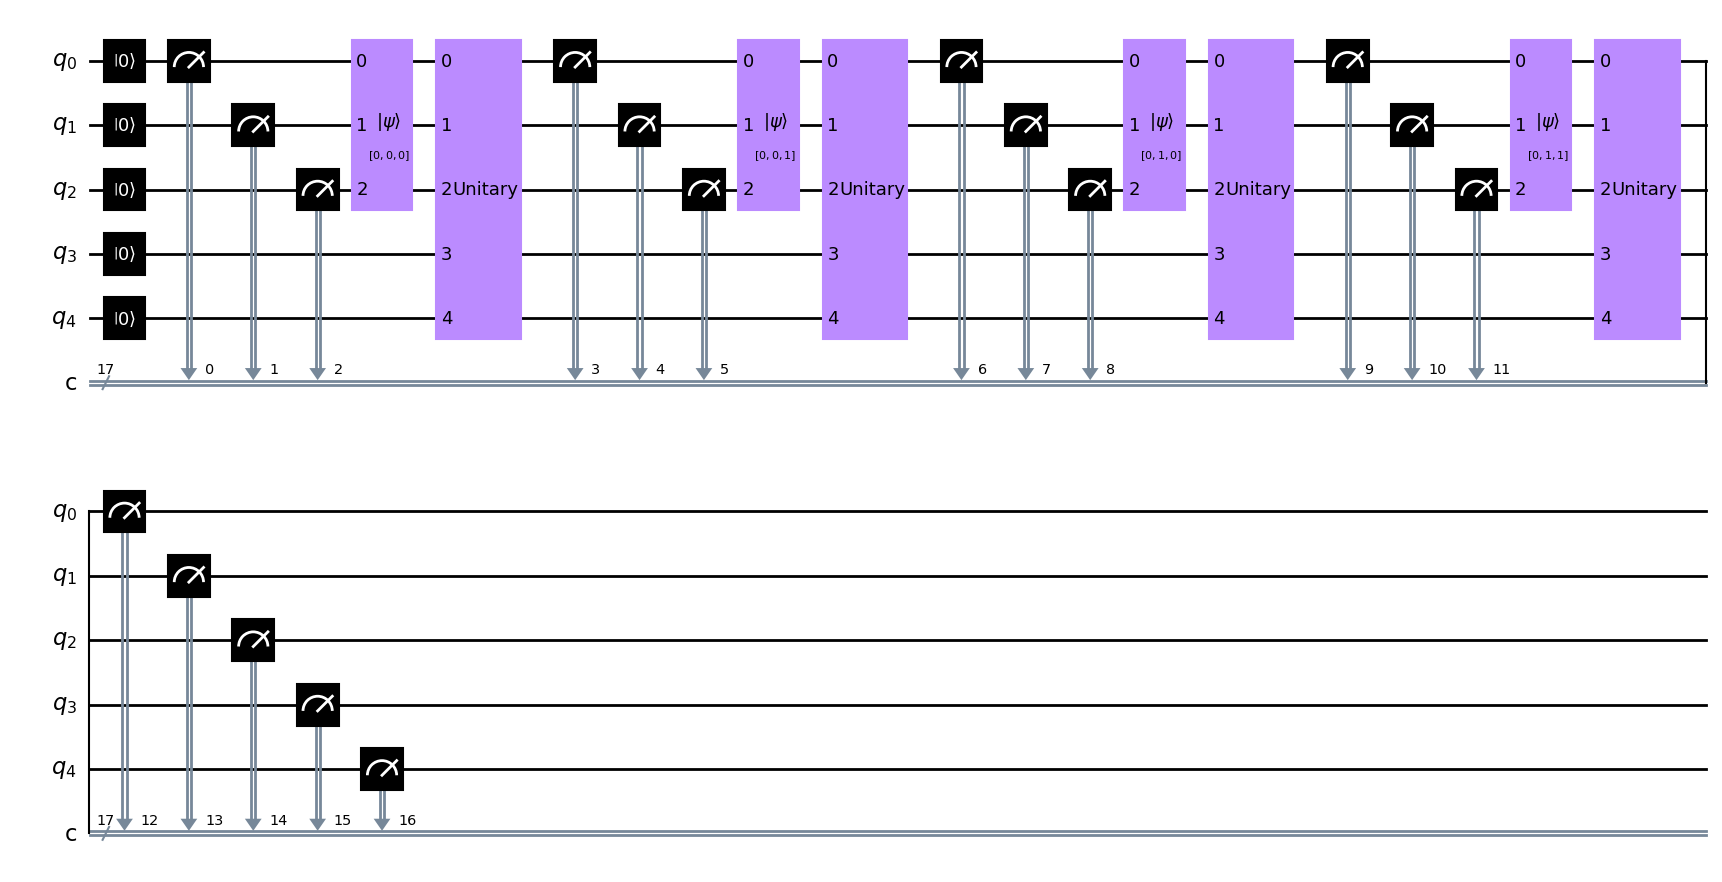

In [19]:
qres.circuit([0, 1, 2, 3], merge_registers=True, transpile=False).draw('mpl')

## Running

In [20]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS
)


Analyzing... : 100%|██████████| 130/130 [02:55<00:00,  1.35s/it] 


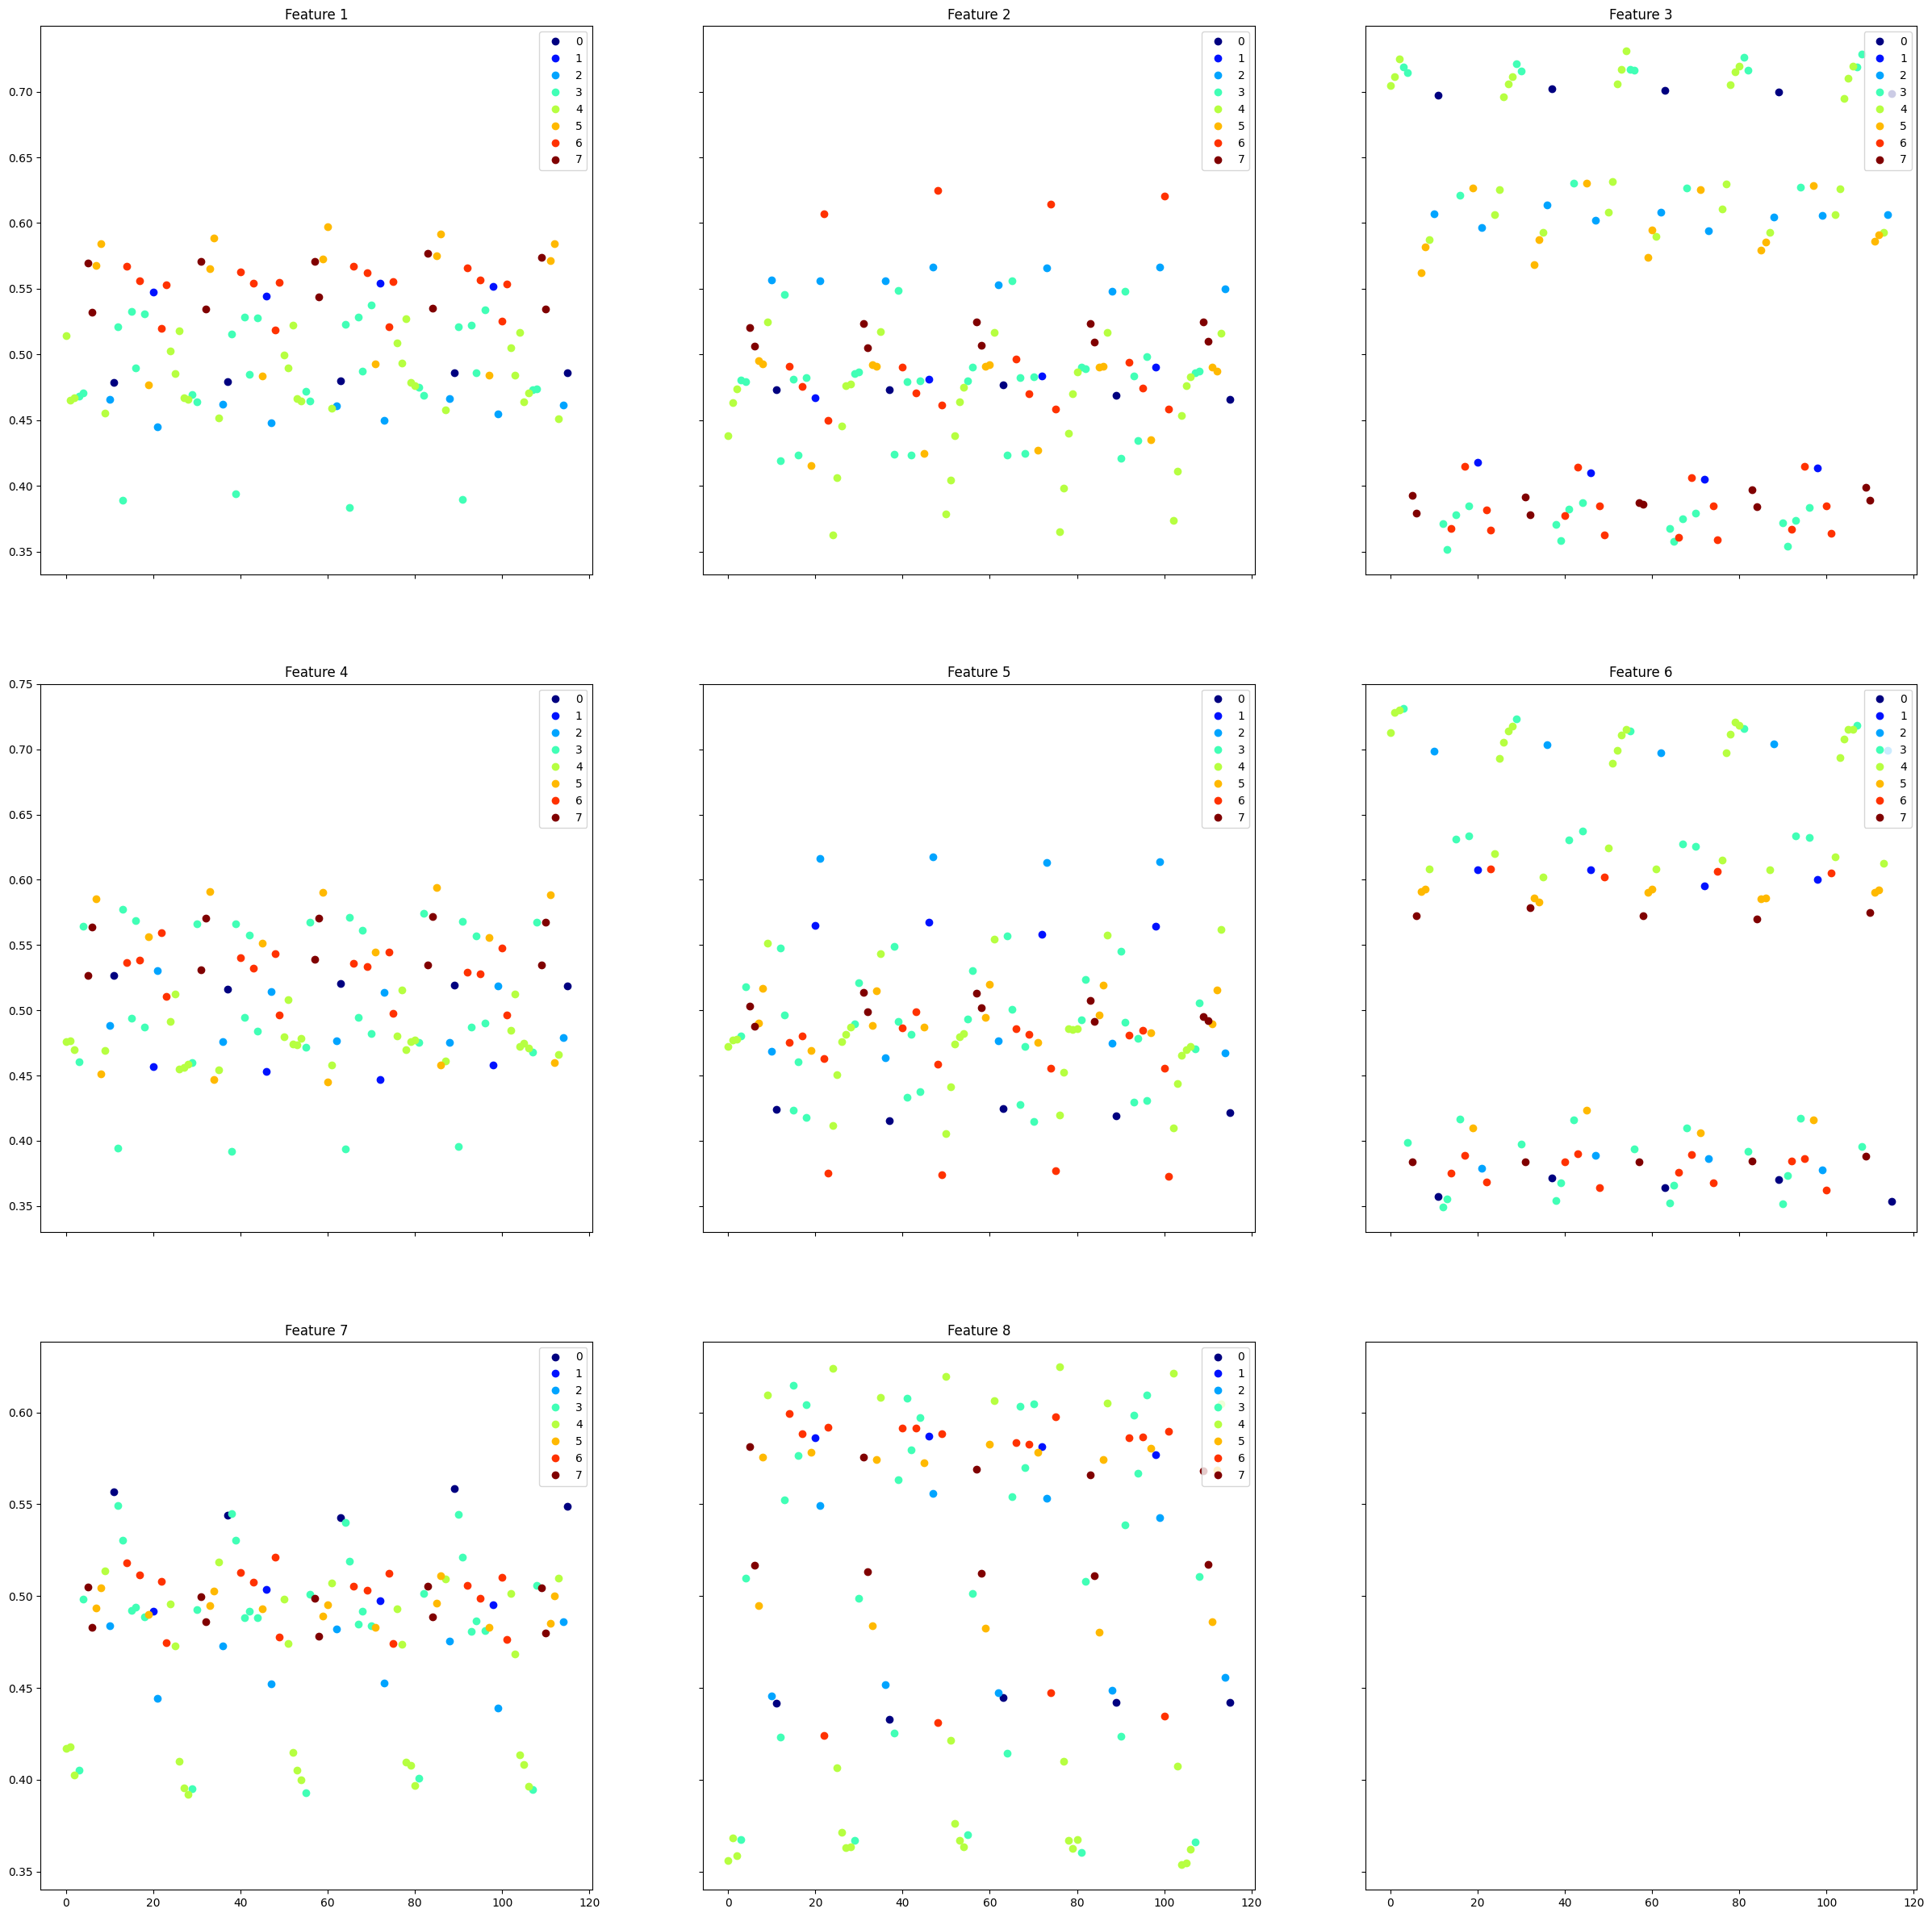

In [21]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]
fig, ax = state_plotter(xstates, target)

Text(0, 0.5, 'state 2')

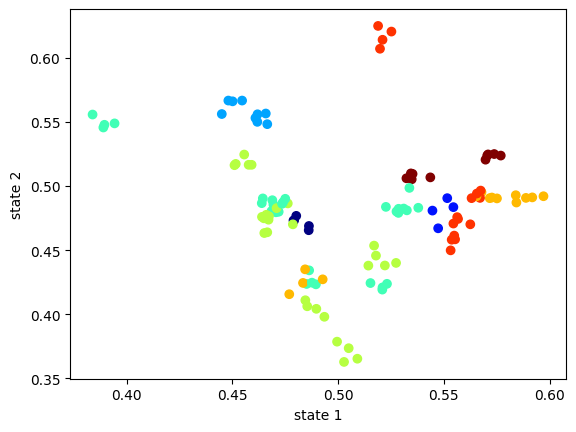

In [22]:



cmap = plt.get_cmap('jet', len(np.unique(timeseries)))

plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)

plt.xlabel("state 1")
plt.ylabel("state 2")


## Training

In [23]:

results = util.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of KNeighborsClassifier(n_neighbors=1): 0.8833333333333329
Score of KNeighborsClassifier(n_neighbors=2): 0.8751282051282041
Score of SVC(kernel='poly'): 0.8725641025641023
Score of KNeighborsClassifier(n_neighbors=3): 0.8169230769230762
Score of KNeighborsClassifier(n_neighbors=4): 0.7664102564102561
Score of SVC(): 0.748461538461538
Score of KNeighborsClassifier(): 0.6520512820512819
Score of RidgeClassifier(alpha=0.0): 0.6243589743589744
Score of RidgeClassifier(alpha=0.00025): 0.6243589743589744
Score of RidgeClassifier(alpha=0.000375): 0.6243589743589744
Score of RidgeClassifier(alpha=0.000625): 0.6243589743589743
Score of RidgeClassifier(alpha=0.00075): 0.6243589743589743
Score of RidgeClassifier(alpha=0.000875): 0.6243589743589743
Score of RidgeClassifier(alpha=0.001): 0.6243589743589743
Score of RidgeClassifier(alpha=0.0005): 0.624102564102564
Score of RidgeClassifier(alpha=0.000125): 0.624102564102564
Score of KNeighborsClassifier(n_neighbors=6): 0.6025641025641024
Score 

## Predicting

In [31]:
chel = 0
c = 1
d = 2
e = 3
ehalv = 6
eåtte = 7
f = 57
ghalv = 5


petter_edderkopp = [
    c, c, c, d, e, e, e, e, d, c, d, e, c
]

predict_from = petter_edderkopp
num_preds = 5*len(predict_from)


preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting...: 100%|██████████| 65/65 [00:15<00:00,  4.30it/s]


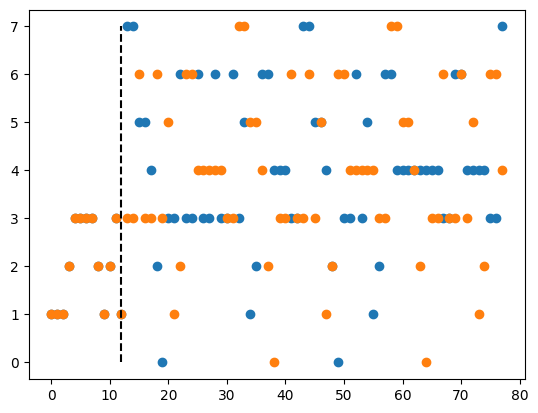

In [32]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.scatter(np.arange(minlen), pred_plot[:minlen], label="Predictions")
plt.vlines(len(predict_from[-num_preds:])-1, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.scatter(np.arange(minlen), true_plot[:minlen], label="True timeseries")


In [33]:
from ulid import ULID

music_encoding = {
    0: (52, 1),
    1: (52, 1/4),
    2: (54, 1/4),
    3: (56, 1/4),
    4: (57, 1/4),
    5: (59, 1/4),
    6: (56, 1/2),
    7: (56, 1/8)
}




notes = [music_encoding[elem] for elem in pred_plot]

music.gen_audio(notes, filename=f"wav/petterEdderkopp.wav", BPM=160)